# Amazon Redset Workload Forecasting

## What is Redset?
Redset is a dataset released by Amazon in 2024, comprising three months of user query metadata from a selected sample of Amazon Redshift instances. It includes query metadata for **200 provisioned and 200 serverless instances**, offering insights into user interactions with these database services. While not representative of the entire Redshift fleet, Redset serves as a valuable resource for developing **new benchmarks and exploring machine learning techniques**, such as **workload forecasting**, tailored to these specific workloads.

## What we perform in this notebook?

In this notebook, we analyze **Amazon Redset**, a dataset containing query metadata from Amazon Redshift instances, to explore **workload forecasting techniques** for **intelligent resource scaling**. Our primary objectives are:

### 1. Baseline Model Evaluation
- We evaluate **traditional forecasting baselines**, such as:
  - **AutoGluon DeepAR**
  - **Seasonal Naive Models**
- These models establish reference points for **workload prediction**.

### 2. Development of RNN-based Forecasting Models
- We implement **Recurrent Neural Network (RNN)-based models** to improve **forecasting accuracy**.
- These models aim to **capture complex workload patterns** and **improve upon the baselines**.

### 3. Comparison Between Baselines and RNN-based Approaches
- Using the **Redset dataset**, we compare the performance of our **custom RNN models** with:
  - **AutoGluon DeepAR**
  - **Statistical forecasting methods** (e.g., ARIMA, ETS)
- We use metrics such as **Q-error** and **forecast accuracy** to assess improvements.

---

### Reference
For more details on the forecasting methodologies and benchmark comparisons, we refer to the **attached paper: "Forecasting Algorithms for Intelligent Resource Scaling: An Experimental Analysis"**.  
This paper provides insights into **workload forecasting challenges**, evaluation metrics, and strategies for improving predictive accuracy in cloud environments.

In [1]:
import pandas as pd
from datetime import datetime
from utility.helpers import DataManager
# import visualization
from utility.baseline_models import DeepAR
import matplotlib.pyplot as plt
import seaborn as sns
datamanager = DataManager('provisioned', 96)
import logging
import os



/Applications/miniconda/envs/mxnet310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
data = datamanager.load_data()
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Sort the data by timestamp
data = data.sort_values('timestamp')

In [3]:
# Visualize data
# visualization.visualize_data(data)
data
import numpy as np
data['query_count'] = np.log1p(data['query_count'])  # Apply log transform

In [ ]:
# Split into training and test data:
# Following the approach in the paper (p. 132), for a cluster with N weeks of data,
# the first train-test split includes N-2 weeks for training and the following week
# for testing. The second train-test split contains the first N-1 weeks for training
# and the following week for testing, representing a scenario of re-training a model
# each week and forecasting for the next week

train1, test1, train2, test2 = datamanager.train_test_split(data)

print(f"train1 shape: {train1.shape}")
print(f"test1 shape: {test1.shape}")
print(f"train2 shape: {train2.shape}")
print(f"test2 shape: {test2.shape}")

print(train1.iloc[-1])
print(test1.iloc[0])
print(train1.iloc[-1])
print(test1.iloc[0])

train1 shape: (1919, 5)
test1 shape: (168, 5)
train2 shape: (2087, 5)
test2 shape: (48, 5)
instance_id                       96
timestamp        2024-05-19 23:00:00
query_count                 0.693147
runtime                         19.0
bytes_scanned                    0.0
Name: 141583, dtype: object
instance_id                       96
timestamp        2024-05-20 00:00:00
query_count                 2.639057
runtime                      20678.0
bytes_scanned                 3045.0
Name: 190321, dtype: object
instance_id                       96
timestamp        2024-05-19 23:00:00
query_count                 0.693147
runtime                         19.0
bytes_scanned                    0.0
Name: 141583, dtype: object
instance_id                       96
timestamp        2024-05-20 00:00:00
query_count                 2.639057
runtime                      20678.0
bytes_scanned                 3045.0
Name: 190321, dtype: object
instance_id                       96
timestamp        202

## Baseline Model: DeepAR

No path specified. Models will be saved in: "AutogluonModels/ag-20250222_104931"
Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.96 GB / 8.00 GB (24.5%)
Disk Space Avail:   22.67 GB / 228.27 GB (9.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'batch_size': 8,
                                'context_length': 48,
                                'dropout_rate': 0.2,
                                'freq': 'H',
                                'hidden_size': 40,
                                '

Data loaded successfully!
Train-Test split completed!
Train1 shape: (1919, 5), Test1 shape: (168, 5)
Initializing DeepARAutogluonTS Model...
Training started using DeepAR...


Provided train_data has 1920 rows (NaN fraction=0.1%), 1 time series. Median time series length is 1920 (min=1920, max=1920). 

Provided data contains following columns:
	target: 'query_count'
Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/models/trainer.pkl
Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/learner.pkl

AutoGluon will gauge predictive performance using evaluation metric: 'SMAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-02-22 11:49:31
Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/utils/data/train.pkl
Models that will be trained: ['DeepAR']
Setting random seed to 123
Training timeseries model DeepAR. 
	Fitting DeepAR with 'num_gpus': 0, 'num_cpus': 8
	-0.2824       = Validation score (-SMAPE)
	115.83  s     = Training runtime
	0.29    s     = Validation (predictio

Training completed using DeepAR.
Model trained successfully!


Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/models/cached_predictions.pkl
Model not specified in predict, will default to the model with the best validation score: DeepAR
Loading: /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/models/cached_predictions.pkl
Loading: /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/models/cached_predictions.pkl
Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250222_104931/models/cached_predictions.pkl


Predictions generated successfully!
Evaluation Metrics:
Q-error: 1.5549
MAE: 0.9451
RME: 0.3314
Evaluation successful!


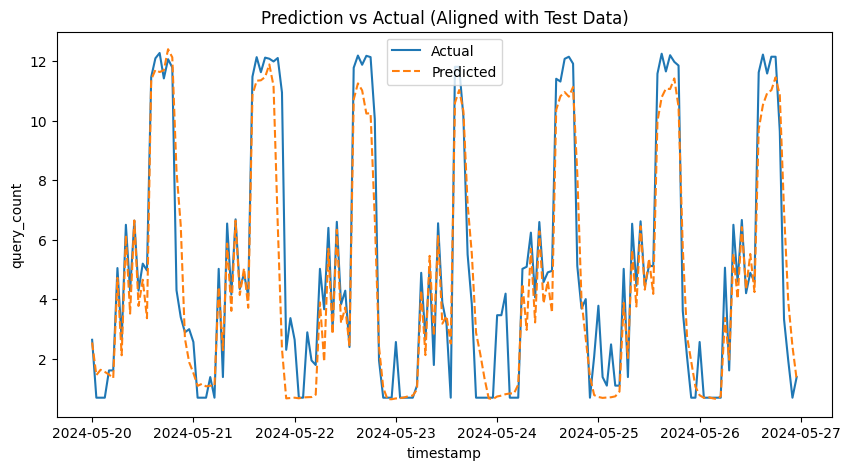

In [4]:
import pandas as pd
import numpy as np
import os
import logging
from utility.helpers import DataManager
from utility.baseline_models import DeepAR
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment variables and logging settings
os.environ["OMP_NUM_THREADS"] = "2"  # Prevent excessive parallelism
os.environ["AUTOGLUON_DEVICE"] = "cpu"  # Ensure CPU-only execution
logging.basicConfig(level=logging.INFO)
logging.getLogger("autogluon").setLevel(logging.DEBUG)

# Global variables
data = None
datamanager = None
train1, test1 = None, None
model = None
predictions = None

# Load data
def load_data(dataset_type, instance_number):
    global data, datamanager
    try:
        datamanager = DataManager(dataset_type, instance_number)
        data = datamanager.load_data()
        data["timestamp"] = pd.to_datetime(data["timestamp"])
        data = data.sort_values("timestamp")
        # Apply log transform to query_count
        data["query_count"] = np.log1p(data["query_count"])
        print("Data loaded successfully!")
        return data.head()
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Perform train-test split (ensures test set follows train set properly)
def train_test_split():
    global train1, test1
    if data is None:
        print("Load data first!")
        return
    try:
        train1, test1, _, _ = datamanager.train_test_split(data)
        
        # Ensure test data starts immediately after train data
        test1 = test1[test1["timestamp"] > train1["timestamp"].max()]
        
        print(f"Train-Test split completed!\nTrain1 shape: {train1.shape}, Test1 shape: {test1.shape}")
    except Exception as e:
        print(f"Error in train-test split: {str(e)}")

# Train DeepAR Model (using test1 length as prediction length)
def train_model():
    global model
    if train1 is None:
        print("Load data and perform train-test split first!")
        return
    
    try:
        prediction_duration = len(test1)  # Ensure model knows correct prediction length
        hyperparameters = {
            'DeepAR': {
                'num_layers': 2,
                'hidden_size': 40,
                'dropout_rate': 0.2,
                'learning_rate': 5e-4,
                'patience': 5,
                'max_epochs': 50,
                'context_length': 48,
                'use_feat_dynamic_real': True,
                'batch_size': 8,
                'freq': 'H',
                'verbosity': 2
            }
        }
        model = DeepAR(prediction_length=prediction_duration, freq="h", hyperparameters=hyperparameters)
        model.train(train1, target_column="query_count")
        print("Model trained successfully!")
    except Exception as e:
        print(f"Error training model: {str(e)}")

# Make predictions strictly within test1 timestamps
def predict():
    global predictions
    if test1 is None or model is None:
        print("Ensure data is loaded, train-test split is done, and model is trained first!")
        return None
    
    try:
        # Ensure we predict strictly within test timestamps
        test_forecast = test1.copy()
        predictions = model.predict(test_forecast, target_column="query_count")
        
        # Match test set timestamps
        predictions["timestamp"] = test_forecast["timestamp"].values
        
        print("Predictions generated successfully!")
        return predictions
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Evaluate model using test data
def evaluate_model():
    if test1 is None or model is None:
        print("Ensure data is loaded, train-test split is done, and model is trained first!")
        return None
    
    try:
        evaluation_results = model.evaluate(test1, target_column="query_count")

        print("Evaluation successful!")
        return evaluation_results
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        return None

# Visualize actual vs predicted values (now aligned with test data)
def visualize_predictions():
    if test1 is None or predictions is None:
        print("Ensure data is loaded and predictions are generated first!")
        return
    
    try:
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=test1["timestamp"], y=test1["query_count"], label="Actual")
        sns.lineplot(x=predictions["timestamp"], y=predictions["mean"], label="Predicted", linestyle="dashed")
        plt.title("Prediction vs Actual (Aligned with Test Data)")
        plt.show()
    except Exception as e:
        print(f"Error visualizing predictions: {str(e)}")

# Example Usage
dataset_type = "provisioned"
instance_number = 96

# Load data
load_data(dataset_type, instance_number)

# Perform train-test split
train_test_split()

# Train model
train_model()

# Make predictions within the test set range
predictions = predict()

# Evaluate model
evaluation_results = evaluate_model()

# Visualize predictions
visualize_predictions()

## PatchTST

Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/g8/AutogluonModels/ag-20250222_165659'


Initializing PatchTST Model...
Training PatchTST...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.74 GB / 8.00 GB (21.8%)
Disk Space Avail:   20.58 GB / 228.27 GB (9.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'h',
 'hyperparameters': {'PatchTST': {'batch_size': 16,
                                  'context_length': 336,
                                  'dropout_rate': 0.2,
                                  'hidden_size': 128,
                                  'learning_rate': 0.0005,
                                  'max_epochs': 50,
                                  'num_layers': 3,
                                  'patience': 5}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'predicti

PatchTST Training Completed.
Evaluation Results: {'q_error': 2.3137305235616603, 'mae': 1.0105302119062198, 'rme': 0.4583626493551793}


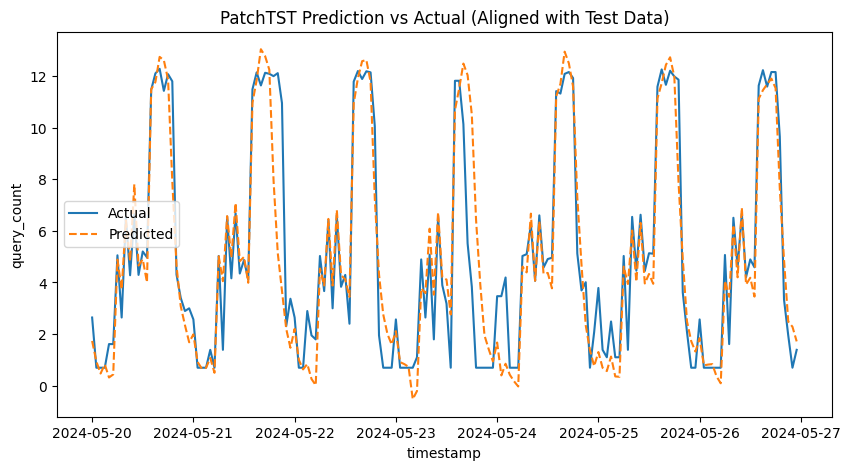

In [1]:
import pandas as pd
import numpy as np
import os
import logging
from typing import Dict, List
from autogluon.timeseries import TimeSeriesPredictor
from utility.helpers import DataManager
import matplotlib.pyplot as plt
import seaborn as sns

class PatchTST:
    """
    PatchTST implementation for time series forecasting using AutoGluon.
    """
    
    def __init__(self, prediction_length: int, freq: str = "h", hyperparameters: Dict = None):
        print("Initializing PatchTST Model...")
        self.prediction_length = prediction_length
        self.freq = freq
        self.model = None
        
        default_patchtst_hp = {
            "num_layers": 3,
            "hidden_size": 128,
            "dropout_rate": 0.2,
            "learning_rate": 5e-4,
            "context_length": prediction_length * 2,
            "batch_size": 16,
            "max_epochs": 50,
            "patience": 5,
        }
        self.hyperparameters = hyperparameters or {"PatchTST": default_patchtst_hp}
    
    def prepare_data(self, data: pd.DataFrame, target_column: str = "query_count") -> pd.DataFrame:
        """
        Prepares data for PatchTST model by formatting it in AutoGluon's long format.
        """
        data = data.copy()
        data["timestamp"] = pd.to_datetime(data["timestamp"])
        data = data.sort_values("timestamp")
        data["item_id"] = "item_1"
        return data[["item_id", "timestamp", target_column]]

    def train(self, train_data: pd.DataFrame, target_column: str = "query_count"):
        """
        Trains the PatchTST model.
        """
        prepared_data = self.prepare_data(train_data, target_column)
        
        print("Training PatchTST...")
        self.model = TimeSeriesPredictor(
            target=target_column,
            prediction_length=self.prediction_length,
            freq=self.freq,
            eval_metric='SMAPE'
        )
        
        self.model.fit(train_data=prepared_data, hyperparameters=self.hyperparameters)
        print("PatchTST Training Completed.")
    
    def predict(self, test_data: pd.DataFrame, target_column: str = "query_count") -> pd.DataFrame:
        """
        Generates predictions strictly within test timestamps.
        """
        if self.model is None:
            raise ValueError("Model must be trained before making predictions.")
        
        prepared_data = self.prepare_data(test_data, target_column)
        predictions = self.model.predict(prepared_data)
        
        forecast = predictions.loc["item_1"].reset_index().rename(columns={"index": "timestamp"})
        mean_forecast = forecast["0.5"] if "0.5" in forecast.columns else forecast.iloc[:, 1]
        
        predictions_df = pd.DataFrame({
            "timestamp": test_data["timestamp"].values,
            "mean": mean_forecast[:len(test_data)]
        })
        
        return predictions_df
    
    def evaluate(self, test_data: pd.DataFrame, target_column: str = "query_count") -> Dict[str, float]:
        """
        Evaluates PatchTST predictions against actual test data.
        """
        if self.model is None:
            raise ValueError("Model must be trained before evaluation.")
        
        predictions_df = self.predict(test_data, target_column)
        actual = test_data[target_column].values
        forecast = predictions_df["mean"].values[:len(actual)]
        
        mae = np.mean(np.abs(forecast - actual))
        q_errors = np.maximum(forecast / (actual + 1e-10), actual / (forecast + 1e-10))
        q_error = np.mean(q_errors)
        rme = np.mean(np.abs(forecast - actual) / (np.abs(actual) + 1e-10))
        
        return {"q_error": q_error, "mae": mae, "rme": rme}
    
    def save_model(self):
        if self.model is None:
            raise ValueError("No trained model to save.")
        self.model.save()
        print("Model saved successfully.")
    
    def load_model(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(f"No model file found at {path}")
        self.model = TimeSeriesPredictor.load(path)
        print(f"Model loaded from {path}.")

# Usage
if __name__ == "__main__":
    dataset_type = "provisioned"
    instance_number = 96
    
    datamanager = DataManager(dataset_type, instance_number)
    data = datamanager.load_data()
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values("timestamp")
    data["query_count"] = np.log1p(data["query_count"])
    
    train1, test1, _, _ = datamanager.train_test_split(data)
    test1 = test1[test1["timestamp"] > train1["timestamp"].max()]
    
    prediction_duration = len(test1)
    model = PatchTST(prediction_length=prediction_duration, freq="h")
    model.train(train1, target_column="query_count")
    predictions = model.predict(test1, target_column="query_count")
    
    evaluation_results = model.evaluate(test1, target_column="query_count")
    print("Evaluation Results:", evaluation_results)
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=test1["timestamp"], y=test1["query_count"], label="Actual")
    sns.lineplot(x=predictions["timestamp"], y=predictions["mean"], label="Predicted", linestyle="dashed")
    plt.title("PatchTST Prediction vs Actual (Aligned with Test Data)")
    plt.show()